# GTI770 - TP03 - Machines à vecteur de support et réseaux neuronaux 

| Étudiants             | GUEGAN - 14059606 - LECHERE - 0305970                                   |
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | AUTOMNE 2019                                            |
| Groupe                | 01                                                       |
| Numéro du laboratoire | 03                                                       |
| Professeur            | Prof. Hervé Lombaert                                               |
| Chargé de laboratoire | Pierre-Luc Delisle
|
| Date                  | DATE         

Ce laboratoire a pour but de manipuler un réseau de nerones à partir de TensorFlow et un modèle de type SVM. Nous nous appuierons sur TensorBoard et Matplotlib pour présenter les résultats en fonction de la taille des données utilisées et des hyperparamètres sélectionnés.

## Plan du TP03
Ce TP aura une structure très simple. Nous allons tout d'abord présenter le code qui permettra de construire les différents modèles en fonction des hyperparamètres et de la taille de l'échantillon de données. Nous essaierons de répondre aux questions du sujets en parallèle lorsque ce sera justifié et à la fin du rapport lorsque nous aurons des interrogations vis-à-vis de la théorie ou de la comparaison des modèles.

#### Question 1 - Choix de la méthode de validation
Nous avons opté pour une K-Cross-Validation pour valider nos modèles. Il nous semblait au'il s'agissait de la méthode la plus appropriée car c'est un bon compromis entre le temps nécessaire et la fiabilité de nos résultats. Nos modèles ont un temps d'apprentissage assez long donc la méthode leave-one-out et leave-p-out rendait le processus bien trop long.
Nous avons choisi F1-Mesure comme métrique car c'est un indicateur qui prend en compte la pécision et le rappel. Nous avons aussi choisi d'étudier le temps d'apprentissage pour validité l'extensibilité de nos modèles. 

### Importation des modules nécessaires

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn import preprocessing
import time
import datetime
from sklearn.model_selection import KFold
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
%reload_ext tensorboard
import csv

Using TensorFlow backend.


### Extraction des données
Nous allons utiliser les données que nous avons extrait lors du TP01 qui seront fusionnées avec celles mises à disposition pour le TP02

In [2]:
df_galaxy_1 = pd.read_csv('galaxy_features', header = 0).drop(['Unnamed: 0', 'central pixel red', 'central pixel green',
                                                               'central pixel blue', 'galaxy_type'], axis = 1)
df_galaxy_2 = pd.read_csv('galaxy_feature_vectors.csv', header = None)
df_galaxy_2 = df_galaxy_2.rename(columns = {df_galaxy_2.columns[0] : df_galaxy_1.columns[0]})
df_galaxy = pd.merge(df_galaxy_1, df_galaxy_2, on = ['image name'])
y_galaxy = df_galaxy[df_galaxy.columns[79]]
X_galaxy = df_galaxy[df_galaxy.columns[1:78]]

#### Question 2 - Normalisation des données
Il est nécessaire de normaliser les données pour qu'elles soient toutes considérées à la même échelle. Nous allons donc soustraire la moyenne et diviser par l'écart-type de chaque caractéristique.

In [3]:
std_scale = preprocessing.StandardScaler().fit(X_galaxy)

X_galaxy = std_scale.transform(X_galaxy)

Maintenant que nous avons toutes nos données nous allons les diviser pour pouvoir étudier la capacité de nos modèles à fonctionner en augmentant le nombre de l'échantillon étudié. Nous allons prendre 10%, 25%, 50%, 75% et 100% de nos données.

In [4]:
X_galaxy_10 = X_galaxy[0:int(X_galaxy.shape[0]/10)]
y_galaxy_10 = y_galaxy[0:int(y_galaxy.shape[0]/10)]

X_galaxy_25 = X_galaxy[0:int(X_galaxy.shape[0]/4)]
y_galaxy_25 = y_galaxy[0:int(y_galaxy.shape[0]/4)]

X_galaxy_50 = X_galaxy[0:int(X_galaxy.shape[0]/2)]
y_galaxy_50 = y_galaxy[0:int(y_galaxy.shape[0]/2)]

X_galaxy_75 = X_galaxy[0:int(3*X_galaxy.shape[0]/4)]
y_galaxy_75 = y_galaxy[0:int(3*y_galaxy.shape[0]/4)]

X_galaxy_data = [X_galaxy_10, X_galaxy_25, X_galaxy_50, X_galaxy_75, X_galaxy]
y_galaxy_data = [y_galaxy_10, y_galaxy_25, y_galaxy_50, y_galaxy_75, y_galaxy]
repartition = [10, 25, 50, 75, 100]

## Réseau neuronaux
Le premier modèle de réseaux de neurones a été imaginé par Rosenblatt et s'appelle le perceptron. Il s'agit d'un réseau de neurones à propagation avant et qui ne contient donc pas de cycles de réajustement. Le réseau de neurones que nous allons présenter sera différent car il aura plusieurs cycles de réajustement. Nous travaillerons sur plusieurs hyperparamètres pour essayer de comprendre comment optimiser un tel modèle et voir comment il réagit au sur-entraînement et sous-entraînement.

#### Question 3 : Structure de notre réseau de neurones
Nous avons construit notre réseau de neurones grâce aux bibliothèques TensorFlow et Keras. Nous avons choisi un modèle Sequential car il est facilement abordable pour des personnes qui construisent leur premier réseau de neurones. Comme son nom l'indique il se construit de manière séquentielle. Il suffit d'imaginer le nombres de couches que l'on désire avec le nombre de perceptrons voulus, la fonction de validation et écrire la ligne de code correspondante à chaque couche.

Nous avons construit un modèle de base en suivant les consignes de l'énoncé. Voici les paramètres que nous avons choisi :

| Nb de couches total | Nb de perceptrons par couches cachées| Nb d’itérations | Coefficient d'apprentissage|
|-----------------------|-----------------------------------------|-------------------|-----------|
| 4 | 100,100 | 60 | 0.0005 |

Nous avons décidé de construire 12 modèles différents à partir de ces caractéristiques en changeant 3 fois chacuns de ces hyperparamètres :

| Nb de couches total | Nb de perceptrons par couches cachées| Nb d’itérations | Coefficient d'apprentissage |
|-----------------------|-----------------------------------------|-------------------|-----------|
| 0 | _ | 60 | 0.0005 |
| 6 | 100,100,100,100,100,100 | 60 | 0.0005 |
| 10 | 100,100,100,100,100,100,100,100,100,100,100 | 60 | 0.0005 |
| 4 | 150,50 | 60 | 0.0005 |
| 4 | 50,150 | 60 | 0.0005 |
| 4 | 1000,1000 | 60 | 0.0005 |
| 4 | 100,100 | 6 | 0.0005 |
| 4 | 100,100 | 600 | 0.0005 |
| 4 | 100,100 | 6000 | 0.0005 |
| 4 | 100,100 | 60 | 1.5 |
| 4 | 100,100 | 60 | 0.5 |
| 4 | 100,100 | 60 | 0.00005 |

Nous avons utilisé la fonction d'activation ReLU pour les couches cachés et la fonction d'activation Softmax pour la dernière couche. Notre fonction de coût est la fonction d'entropie croisée car nous somme dans un cas de classification binaire et qu'il s'agit d'une fonction qui ne va pas être trop gourmande en temps de calcul et qui à un lien avec la perplexité, c'est à dire l'efficacité de notre modèle à exécuter une tâche.

Ici nous normalisons nos données.

In [5]:
y_galaxy = keras.utils.to_categorical(y_galaxy, num_classes=2)
std_scale = preprocessing.StandardScaler().fit(X_galaxy)
X_galaxy = std_scale.transform(X_galaxy)

Tensorboard n'a pas de F1-Mesure dans sa bibliothèaue, nous l'avons donc redéfini.

In [6]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Création de nos listes d'essai.

In [7]:
list_essai = [[[100,100],60,0.0005],
              [[],60,0.005],
              [[100,100,100,100],60,0.0005],
              [[100,100,100,100,100,100,100,100],60,0.0005],
              [[150,50],60,0.0005],
              [[50,150],60,0.0005],
              [[1000,1000],60,0.0005],
              [[100,100],6,0.0005],
              [[100,100],600,0.0005],
              [[100,100],6000,0.0005],
              [[100,100],60,1.5],
              [[100,100],60,0.5],
              [[100,100],60,0.00005]]

nom_essai = ['base',
            'zero_couches',
            'six_couches',
            'dix_couches',
            'nb_neurones_1',
            'nb_neurones_2',
            'nb_neurones_3',
            '6_epochs',
            '600_epochs',
            '6000_epochs',
            'lr_1',
            'lr_2',
            'lr_3']

## Remarque
Comme l'entraînement de tous nos modèles était très long nous avons joint les fichiers nécessaires à l'ouverture de TensorBoard, ils sont nommés en fonction de la caractéristique aue nous avons modifié.
Il n'est donc pas nécessaire de faire tourner la celulle suivante.

In [ ]:
list_time_learn = []
list_time_test = []
list_loss = []
list_accuracy = []
list_f1_score = []

for k in range(len(list_essai)) :
    model = keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(X_galaxy.shape[1],)))
    for l in list_essai[k][0] :
        model.add(keras.layers.Dense(l, activation = 'relu'))
    model.add(keras.layers.Dense(2, activation = 'softmax'))

    model.compile(optimizer=keras.optimizers.SGD(list_essai[k][2]),
                 loss='binary_crossentropy',
                 metrics=['accuracy',f1_m])

    log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + nom_essai[k]
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    model.fit(X_galaxy, 
              y_galaxy,
              batch_size=100,
              epochs=list_essai[k][1],
              validation_split = 0.2,
              callbacks=[tensorboard_callback]
              )
    
    n_split=5
    
    sub_learn = []
    sub_test = []
    sub_loss = []
    sub_accuracy = []
    sub_f1_score = []
 
    for train_index, test_index in KFold(n_split).split(X_galaxy):
        X_train,X_test=X_galaxy[train_index],X_galaxy[test_index]
        y_train,y_test=y_galaxy[train_index],y_galaxy[test_index]
        
        std_scale = preprocessing.StandardScaler().fit(X_train)
        X_train = std_scale.transform(X_train)  
        X_test = std_scale.transform(X_test)        
        
        t_learn = time.time()
        model.fit(X_train, 
                  y_train,
                  epochs=list_essai[k][1],
                  batch_size=100)
        t_learn = time.time() - t_learn
        
        t_test = time.time()
        loss, accuracy, f1_score = model.evaluate(X_test, y_test)
        t_test = time.time()
        
        sub_learn.append(t_learn)
        sub_test.append(t_test)
        sub_loss.append(loss)
        sub_accuracy.append(accuracy)
        sub_f1_score.append(f1_score)
    
    list_time_learn.append(np.mean(sub_learn))
    list_time_test.append(np.mean(sub_test))
    list_loss.append(np.mean(sub_loss))
    list_accuracy.append(np.mean(sub_accuracy))
    list_f1_score.append(np.mean(sub_f1_score))    

In [ ]:
pd.DataFrame(list_time_learn).to_csv('list_time_learn')
pd.DataFrame(list_time_test).to_csv('list_time_test')
pd.DataFrame(list_loss).to_csv('list_loss')
pd.DataFrame(list_accuracy).to_csv('list_accuracy')
pd.DataFrame(list_f1_score).to_csv('list_f1_score')

Cellule permettant l'ouverture de TensorBoard

In [13]:
import os
os.getcwd()
os.makedirs('logs', exist_ok=True)
%tensorboard --logdir logs/fit --host localhost --port 8080

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 12524.

#### Question 4 - Sur-apprentissage
Les graphiques nous ont permis de mettre en évidence le phénomène de sur-apprentissage. En effet sur le graphe suivant où nous avons mis le nombre d'itérations égale à 6000 on remarque la fonction de perte de la validation augmente après 2000 epochs.
![Sur-apprentissage](Graphe/loss_6000.PNG)
En orange nous avons la courbe pour les données d'entrainement et en bleu pour les données de validation. Le phénomène est très visible ici car le modèle continue à performer sur le jeu d'entraînement mais une fois qu'il passe un certain nombre d'itération, la courbe de la validation ne suit plus. En effet le modèle est trop entraîné sur les données initiales et ne se généralise pas. On peut estimer, d'après ce graphique, que le nombre optimal d'epochs est autour de 2000. 

In [16]:
list_time_learn = pd.read_csv('list_time_learn',index_col = 0)
list_time_learn = [list_time_learn.iloc[k][0] for k in range(13)]
list_time_test =  pd.read_csv('list_time_test',index_col = 0)
list_time_test = [list_time_test.iloc[k][0] for k in range(13)]
list_loss = pd.read_csv('list_loss',index_col = 0)
list_loss = [list_loss.iloc[k][0] for k in range(13)]
list_accuracy = pd.read_csv('list_accuracy',index_col = 0)
list_accuracy = [list_accuracy.iloc[k][0] for k in range(13)]
list_f1_score = pd.read_csv('list_f1_score',index_col = 0)
list_f1_score = [list_f1_score.iloc[k][0] for k in range(13)]

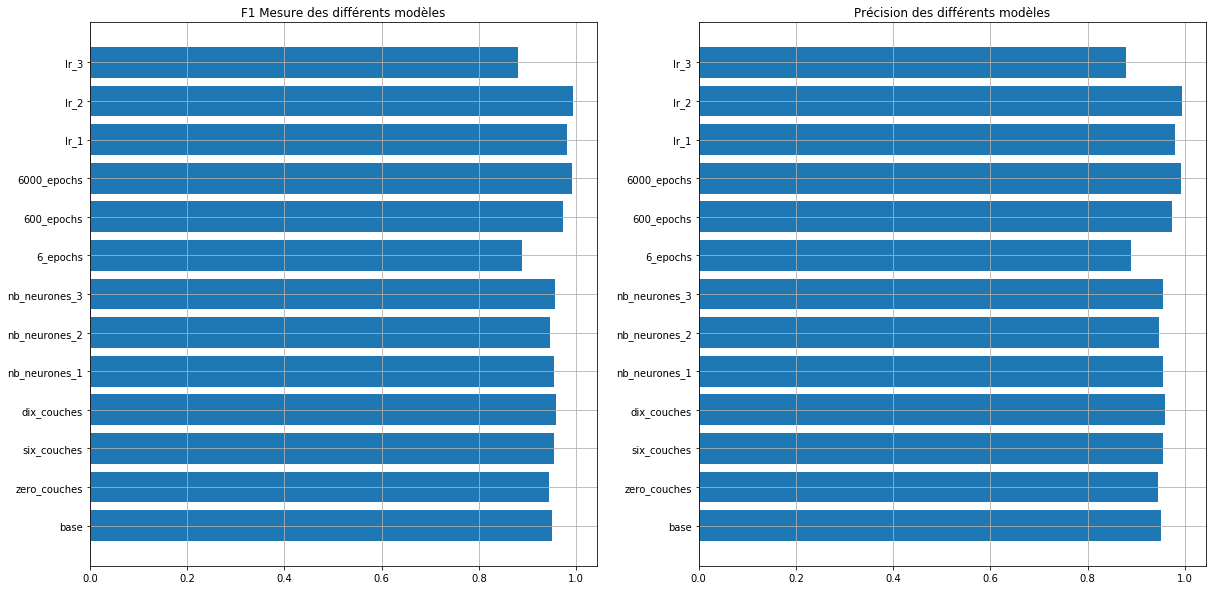

In [22]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.barh(nom_essai, list_f1_score)
plt.title('F1 Mesure des différents modèles')
plt.grid()

plt.subplot(1,2,2)
plt.barh(nom_essai, list_accuracy)
plt.title('Précision des différents modèles')
plt.grid()

A vue d'oeil on remarque que les modèles avec 6000 et 600 epochs ainsi que ceux qui ont un learning rate égale à 1,5 et 0,5 se détachent en terme de précision et de f1-mesure, ils présentent les meilleurs performance.

Rappelons que le nombre d'epochs correspond au nombre d'itérations que fait le modèle pour se réajuster vis à vis des données d'entraînement. Ce paramètre permet donc de se rapprocher du meilleur compromis entre sous-apprentissage et sur-apprentissage.

Le learning rate est un paramètre qui rentre en compte dans la méthode de descente des gradients utilisée pour trouver un minimum global et donc la meilleure performance. Ce coefficient permet de calculer la distance entre chaque point étudié.

Le nombre de neurones par couche permet de spécifier un ordre de grandeur des calculs à effectuer par l'algorithme et le nombre de couches va permettre de linéariser le problème.

D'après ce qu'on a pu voir à la question précédente il vaut mieux écarter le modèle avec 6000 itérations car il présente un problème de généralisation.

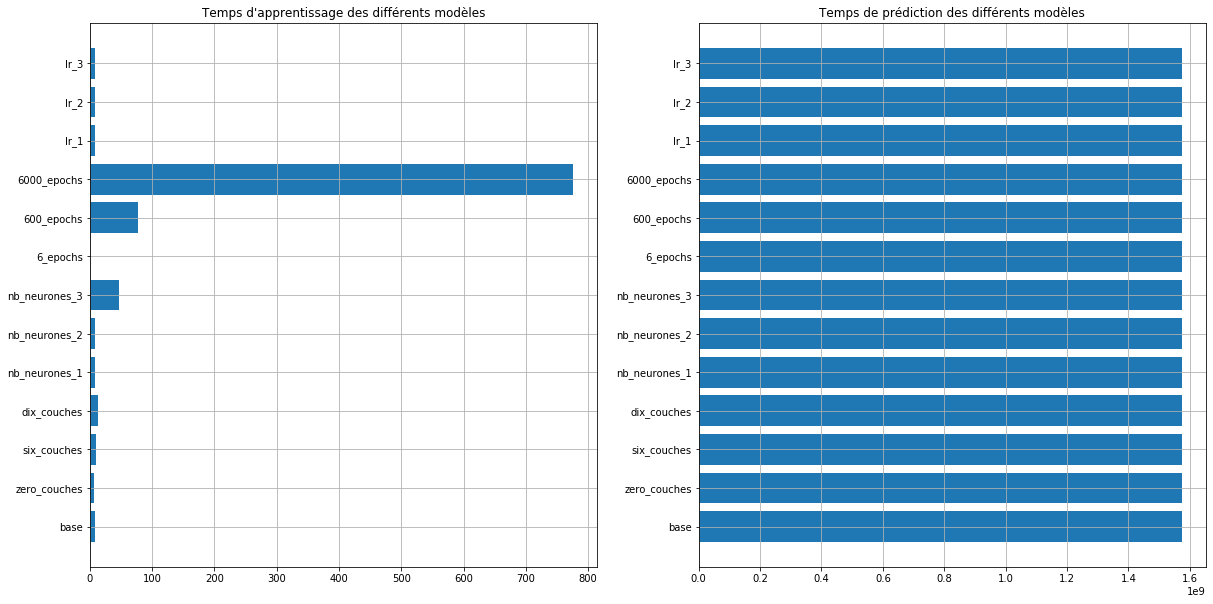

In [24]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.barh(nom_essai, list_time_learn)
plt.title('Temps d\'apprentissage des différents modèles')
plt.grid()

plt.subplot(1,2,2)
plt.barh(nom_essai, list_time_test)
plt.title('Temps de prédiction des différents modèles')
plt.grid()

On remarque qu'importe le modèle choisi le temps de prédiction est le même et il est très rapide (moins d'1,6 seconde). Cependant les temps d'entraînement sont très différents et le nombre de neurones et le nombre d'itérations sont les principaux paramètres à l'origine de ce phénomène.

## Machine à vecteurs de support
Ce modèle a été imaginé grâce à la théorie de Vapnik-Tchervonenkis et est populaire pour sa capacité à s'adapter aux grands échantillons de données.
La première idée sur laquelle repose les SVM est qu'il existe une marge, un espace entre les frontières de séparations des labels, qui peut être maximisé et donc finie. On cherche donc à délimiter cette marge pour ensuite classifier les nouvelles données.
La notion avancée ci-dessous est très efficace pour des problèmes linéaires mais une fois que nous passons dans des cas non linéaires, ce modèle pourrait montrer ses limites. Heureusement il existe une seconde idée dite kernel trick. Nous considérons maintenant le problème dans un espace de dimension supérieur, voir infinie. Et il est maintenant probable qu'il existe une séparation linaire. Il est nécessaire d'introduire une fonction noyau qui permettra de faciliter les calculs et qui a l'avantage d'avoir une forme simple.
Nous allons étudier deux fonctions de noyau différentes : linear (polynomiale) et radial base function (s'inspire d'un modèle gaussien).

### SVM - Linear - Étude du paramètre C
Pour ce modèle nous allons dans une première partie le construire avec une fonction noyeau linéaire.
Le paramètre étudié ici est C. Le paramètre C permet de pénaliser les points mal classifiés dans la marge. Pour des valeurs plus grandes de C, une marge plus petite sera acceptée si la fonction de décision permet de classer correctement tous les points d’entraînement, un C trop élevé sera synonymes de sur-apprentissage. Un C plus faible encouragera une marge plus grande, donc une fonction de décision plus simple, au détriment de la précision de l'entraînement et donc un sous-apprentissage dans les cas extrêmes.

In [7]:
C_range = [0.001, 0.1, 1, 10]
resultat_score_svm = []
resultat_time_svm = []

for k in C_range :
    clf = SVC(C = k, kernel = 'linear', class_weight = 'balanced', cache_size = 2048)
    t = time.time()
    score = cross_val_score(clf, X_galaxy_10, y_galaxy_10, cv=10, scoring='f1_macro').mean()
    t = time.time() - t
    resultat_score_svm.append(score)
    resultat_time_svm.append(t)
    print(score)

0.8908814597472288
0.9359289493344936
0.9377430758931322
0.9347841048003366


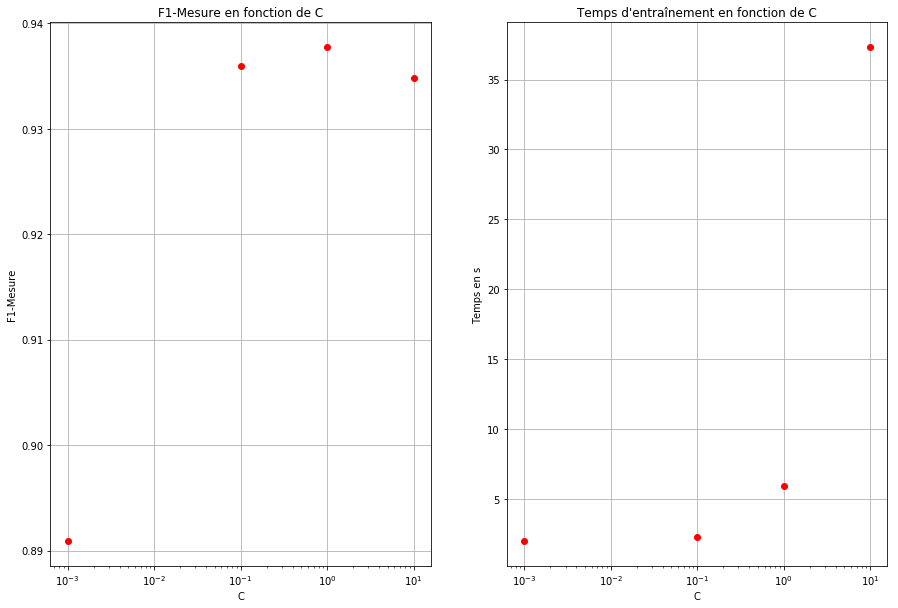

In [10]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.grid()
plt.plot(C_range, resultat_score_svm, 'ro')
plt.title('F1-Mesure en fonction de C')
plt.xlabel('C')
plt.ylabel('F1-Mesure')
plt.xscale('log')

plt.subplot(1,2,2)
plt.plot(C_range, resultat_time_svm, 'ro')
plt.title('Temps d\'entraînement en fonction de C')
plt.xlabel('C')
plt.ylabel('Temps en s')
plt.xscale('log')
plt.grid()

Pour C = 1 nous avons unre très bonne F1-Mesure et un temps d'apprentissage très correct.

### Étude de la capacité du modèle à s'adapter à la taille de l'échantillon
Pour étudier la scalability nous prendrons le meilleur paramètre de l'étude précédente.

In [11]:
scalability_score_svm = []
scalability_time_svm = []

best_C = C_range[np.argmax(resultat_score_svm)]

clf = SVC(C = best_C, kernel = 'linear', class_weight = 'balanced', cache_size = 2048)
        
for k in range(len(X_galaxy_data)):
    t = time.time()
    score = cross_val_score(clf, X_galaxy_data[k], y_galaxy_data[k], cv=10, scoring='f1_macro').mean()
    t = time.time() - t
    scalability_score_svm.append(score)
    scalability_time_svm.append(t)
    print(score)

0.9377430758931322
0.9405572590588435
0.9451162321298785
0.9480236633297926
0.9481934788212516


Text(0, 0.5, 'F1-Mesure')

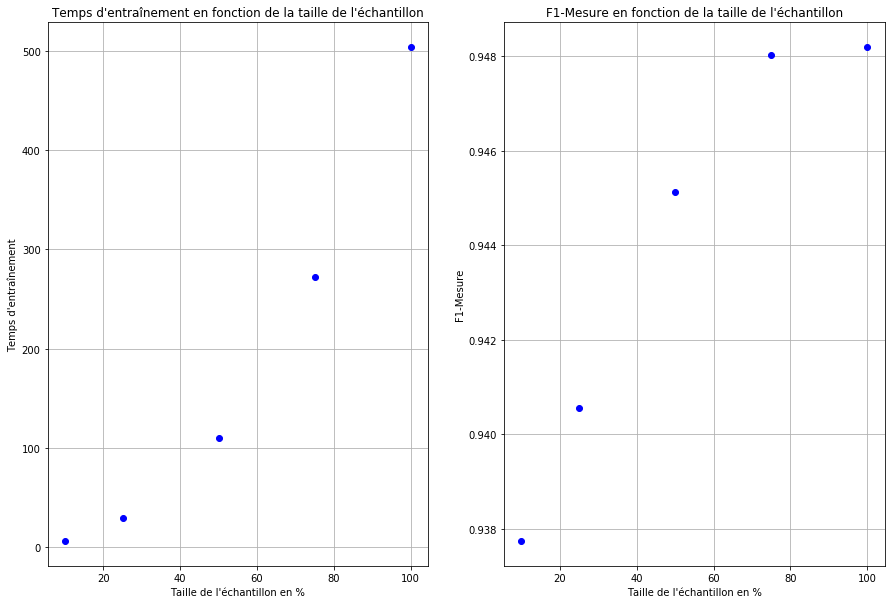

In [17]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.grid()
plt.plot(repartition, scalability_time_svm,'bo')
plt.title('Temps d\'entraînement en fonction de la taille de l\'échantillon')
plt.xlabel('Taille de l\'échantillon en %')
plt.ylabel('Temps d\'entraînement')

plt.subplot(1,2,2)
plt.grid()
plt.plot(repartition, scalability_score_svm,'bo')
plt.title('F1-Mesure en fonction de la taille de l\'échantillon')
plt.xlabel('Taille de l\'échantillon en %')
plt.ylabel('F1-Mesure')

On remarque que notre modèle supporte très bien l'extensibilité de nos données. En effet plus nous avons de données et plus il devient performant. Bien sur il y un temps d'entraînement qui est nécessairement plus long. Il serait donc préférable, dans la configuration où nous sommes d'opter pour un échantillon de 75% des données totales pour un bon compromis entre performance et temps d'apprentissage.

### SVM - RBF - Étude des paramètres C et gamma
Dans ce second modèle nous allons étudier les paramètres C et gamma avec une fonction radiale de base. Intuitivement, le paramètre gamma définit la portée de l’influence d’un seul exemple d’entraînement, les valeurs basses signifiant «loin» et les valeurs élevées signifiant «proche». Les paramètres gamma peuvent être vus comme l'inverse du rayon d'influence des échantillons sélectionnés par le modèle en tant que vecteurs de support.

In [13]:
gamma_range = C_range
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs = -1)
grid.fit(X_galaxy_10, y_galaxy_10)
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10, 'gamma': 0.001} with a score of 0.94


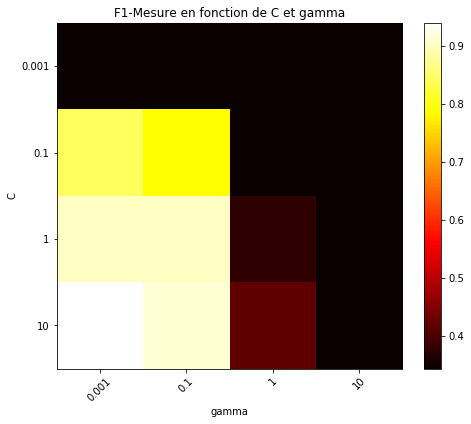

In [20]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('F1-Mesure en fonction de C et gamma')
plt.show()

Grâce au module qui nous permet de croiser les hyperparamètres il apparaît que le meilleur couple est C = 10 et gamma = 0.001.

### Étude de la capacité du modèle à s'adapter à la taille de l'échantillon
Pour étudier la scalability nous prendrons les meilleurs paramètres de l'étude précédente.

In [21]:
scalability_score_rbf = []
scalability_time_rbf = []

best_C = grid.best_params_["C"]
best_gamma = grid.best_params_["gamma"]

clf = SVC(C = best_C, gamma = best_gamma, cache_size = 2048)
        
for k in range(len(X_galaxy_data)):
    t = time.time()
    score = cross_val_score(clf, X_galaxy_data[k], y_galaxy_data[k], cv=10, scoring='f1_macro').mean()
    t = time.time() - t
    scalability_score_rbf.append(score)
    scalability_time_rbf.append(t)
    print(score)

0.941276633565385
0.9431563391301147
0.9524407933393908
0.956377671017069
0.9580003735993727


Text(0, 0.5, 'F1-Mesure')

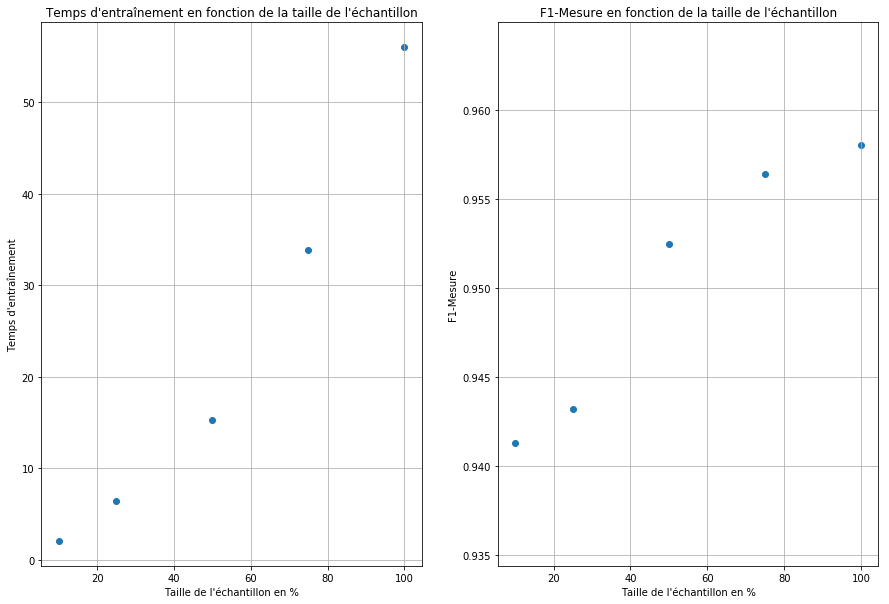

In [22]:
plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.grid()
plt.scatter(repartition, scalability_time_rbf)
plt.title('Temps d\'entraînement en fonction de la taille de l\'échantillon')
plt.xlabel('Taille de l\'échantillon en %')
plt.ylabel('Temps d\'entraînement')

plt.subplot(1,2,2)
plt.grid()
plt.scatter(repartition, scalability_score_rbf)
plt.title('F1-Mesure en fonction de la taille de l\'échantillon')
plt.xlabel('Taille de l\'échantillon en %')
plt.ylabel('F1-Mesure')

On remarque que notre modèle supporte très bien l'extensibilité de nos données. En effet plus nous avons de données et plus il devient performant. Bien sur il y un temps d'entraînement qui est nécessairement plus long. Il serait donc préférable, dans la configuration où nous sommes d'opter pour un échantillon de 75% des données totales pour un bon compromis entre performance et temps d'apprentissage.

#### Question 6 - Méthodologie de sélection de nos hyperparamètres
Comme il l'était justement conseillé nous avons choisi mesurer la F1-Mesure et le temps d'apprentissage pour choisir les bon hyperparamètres. Ainsi pour le modèle linéaire nous avons fait varier la valeur de C pour étudier les performances. Avec un C=1 nous avions le meilleur compromis entre temps d'apprentissage et performance.

Pour le modèle radial nous avons fait varier C et gamma grâce à une méthode de croisement de toutes les valeurs possibles des paramètres. Nous avons ainsi dégager le meilleur couple : C = 10 et gamma = 0.001.

Nous l'avons déjà mentionné mais le paramètre C permet de pénaliser les points mal classifiés dans la marge. Pour des valeurs plus grandes de C, une marge plus petite sera acceptée si la fonction de décision permet de classer correctement tous les points d’entraînement, un C trop élevé sera synonymes de sur-apprentissage. Un C plus faible encouragera une marge plus grande, donc une fonction de décision plus simple, au détriment de la précision de l'entraînement et donc un sous-apprentissage dans les cas extrêmes.

Le paramètre gamma définit la portée de l’influence d’un seul exemple d’entraînement, les valeurs basses signifiant «loin» et les valeurs élevées signifiant «proche». Les paramètres gamma peuvent être vus comme l'inverse du rayon d'influence des échantillons sélectionnés par le modèle en tant que vecteurs de support.

#### Question 7 - Étude de l'extensibilité de nos modèles

#### Question 8 - Le modèle optimal

Commençons par sortir les meilleurs modèles du réseau de neurones et du SVM. Si on prend individuellement chaque paramètre avec sa fonction de perte, son temps d'entraînement et sa précision on peut combiner le modèle suivant pour le réseau de neurones :
- Learning rate = 0,5
- Epochs = 2000
- 4 couches
- Nombre de neurones par couches cachées = 100

Pour le SVM, le modèle RBF est le meilleur avec :
- C = 10
- gamma = 0.001

Au vue des résultats en terme de performance il semblerait que le réseau de neurones soit meilleur que le SVM.

#### Question 9 - Améliorations

Nous arrivons maintenant à la fin de ce TP et au vu de tout ce que nous avons pu faire il semblerait que nous pouvions encore rajouter quelques améliorations. En effet nous avons confronté différents paramètres mais de manière individuelle pour le réseau de neurones. Nous aurions pu comme dans le cas du SVM RBF confronter les différents paramètre en duo pour trouver les meilleurs couples. Nous aurions aussi pu faire ceci mais pour confronter les performances en fonction du des paramètres et de l'extensibilité des modèles.

## Résumé
Dans ce TP nous avons pu assimiler deux nouveaux modèles avec leurs différents concepts et aussi leur mise en oeuvre pratique avec du code python. Nous avons aussi pu exploiter TensorBoard qui est un excellent outil de visualisation des performances de nos modèles. De plus cet exercice était très formateur pour se projeter dans un futur métier de Data Scientist et comprendre quelles sont les méthodes à exploiter pour trouver le meilleur modèle.